# CAPSTONE 3. Predicting Bitcoin Price
## Exploratory Data Analysis
In this notebook we will perform Exploratory Data Analysis. The goal of this notebook is to take a closer look at our data and see if we can extract any insights from it. We will examine the feature correlation, time series stationarity and autocorrelation.<br>
Let's start.

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
from functools import reduce
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from scipy.stats import linregress
warnings.filterwarnings('ignore')

#setting default figure size
sns.set(rc={"figure.figsize":(12, 6)})
plt.rcParams['figure.figsize'] = (12, 6)

sns.set_style('whitegrid')

#showing only 2 decimals for floats
pd.options.display.float_format = "{:.3f}".format

In [2]:
df = pd.read_csv('../DW/Data_for_EDA.csv')

### Data Overview

In [3]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [4]:
df.head()

,Date,Coin,Price,Market_Cap,Volume
0,2013-04-28,BTC,135.300,1500517590.000,0.000
1,2013-04-29,BTC,141.960,1575032004.000,0.000
2,2013-04-30,BTC,135.300,1501657493.000,0.000
3,2013-05-01,BTC,117.000,1298951550.000,0.000
4,2013-05-02,BTC,103.430,1148667722.000,0.000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3007 entries, 0 to 3006
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        3007 non-null   object 
 1   Coin        3007 non-null   object 
 2   Price       3007 non-null   float64
 3   Market_Cap  3007 non-null   float64
 4   Volume      3007 non-null   float64
dtypes: float64(3), object(2)
memory usage: 117.6+ KB


As we know from the Data Wrangling step, we don't have any missing values, out dates are Datetime objects and the numbers are floats. Now, let's see the period our data spans for and take a look at the summary statistics for each of the tokens.

In [6]:
print(df['Date'].min())
print(df['Date'].max())

2013-04-28
2021-07-24


The earliest observation we have was made on April 28, 2013. The latest one was made on July 24, 2021. Now let's take a look at the summary statistics.

In [7]:
df.describe()

,Price,Market_Cap,Volume
count,3007.000,3007.000,3007.000
mean,6862.136,123731083444.544,10817761706.417
std,11438.901,213666094249.009,18023857867.039
min,67.809,771368060.000,0.000
25%,432.118,6307451188.750,73603956.311
50%,2444.494,40066457532.227,1637948558.256
75%,8645.599,151928682321.364,18547136695.891
max,63576.676,1187737045885.174,178894068361.353


We can see from the statistics above that 'total_volume' and 'market_cap' are quite huge. To make it easier for observing we will add two columns with volume values shown <b>in millions</b> and market_cap values shown <b>in billions</b>

In [8]:
#volume in millions
df['Volume_Mil'] = df['Volume'] / 1000000

#market capitalization in billions
df['Market_Cap_Bil'] = df['Market_Cap'] / 1000000000

In [9]:
df.head(3)

,Date,Coin,Price,Market_Cap,Volume,Volume_Mil,Market_Cap_Bil
0,2013-04-28,BTC,135.300,1500517590.000,0.000,0.000,1.501
1,2013-04-29,BTC,141.960,1575032004.000,0.000,0.000,1.575
2,2013-04-30,BTC,135.300,1501657493.000,0.000,0.000,1.502


In [10]:
col = df.pop("Market_Cap_Bil")
df.insert(4, col.name, col)

In [11]:
df = df.sort_values(by='Date')
df.head()

,Date,Coin,Price,Market_Cap,Market_Cap_Bil,Volume,Volume_Mil
0,2013-04-28,BTC,135.300,1500517590.000,1.501,0.000,0.000
1,2013-04-29,BTC,141.960,1575032004.000,1.575,0.000,0.000
2,2013-04-30,BTC,135.300,1501657493.000,1.502,0.000,0.000
3,2013-05-01,BTC,117.000,1298951550.000,1.299,0.000,0.000
4,2013-05-02,BTC,103.430,1148667722.000,1.149,0.000,0.000


Now we'll take a look at the summary statistics of each coin.<br>
#### NOTE: IT IS IMPORTANT TO MENTION THAT THE DATA WAS AQUIRED FROM ONE PARTICULAR CRYPTO EXCHANGE SO IT MAY VARY FROM OTHER EXCHANGES AND AGGREGATORS. WE WILL PERFROM ANALYSIS BASED ON THE DATA AQUIRED FROM COINGECKO.COM

In [12]:
df.describe()

,Price,Market_Cap,Market_Cap_Bil,Volume,Volume_Mil
count,3007.000,3007.000,3007.000,3007.000,3007.000
mean,6862.136,123731083444.544,123.731,10817761706.417,10817.762
std,11438.901,213666094249.009,213.666,18023857867.039,18023.858
min,67.809,771368060.000,0.771,0.000,0.000
25%,432.118,6307451188.750,6.307,73603956.311,73.604
50%,2444.494,40066457532.227,40.066,1637948558.256,1637.949
75%,8645.599,151928682321.364,151.929,18547136695.891,18547.137
max,63576.676,1187737045885.174,1187.737,178894068361.353,178894.068


Great. Now it's much easier to see the trading volume and market capitalization.
First we will find out how Bitcoin prices changed in 2020.

In [13]:
startdate = dt.datetime.strptime('2019-12-31', "%Y-%m-%d").date()
enddate = dt.datetime.strptime('2020-12-31', "%Y-%m-%d").date()
mask = (df['Date'] > startdate) & (df['Date'] < enddate)
df_2020 = df[mask]

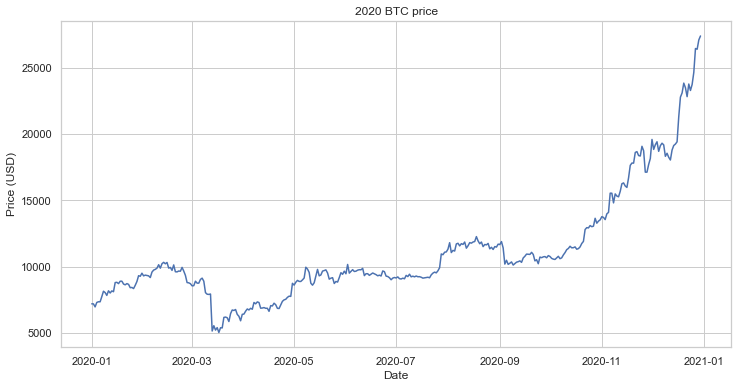

In [14]:
sns.lineplot(data=df_2020, x='Date', y='Price')
plt.title(f'2020 BTC price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

We see that BTC started fast growth right after the COVID-19 panic was over in March 2020.<br>
But this is only for 2020. Let's take a look at all time data.

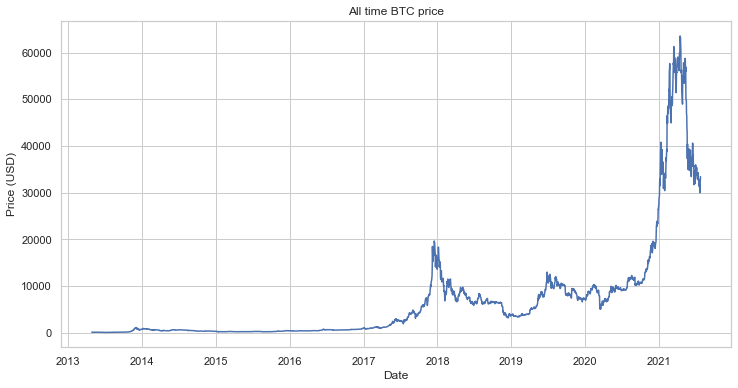

In [15]:
sns.lineplot(data=df, x='Date', y='Price')
plt.title(f'All time BTC price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

NOTE: Bitcoin is the first and largest cryptocurrency. It was created in 2008, but it didn't get much of attention since 2015-2017. In 2017 first really big bull run happened (in terms of actual price, not return). We can see on the graph that in the middle of 2017 bitcoin started rapid growth, peaked at the end of 2017 - beginning of 2018 and then dropped. By the beginning of 2019 Bitcoin price was pretty much the same as before the 2017 bull run. We can see a similar pattern of the second major bull run which started at the end of 2020, peaked at the beginning of 2021 and then price dropped again.

Now we will take a look at Bitcoin market cap in 2020

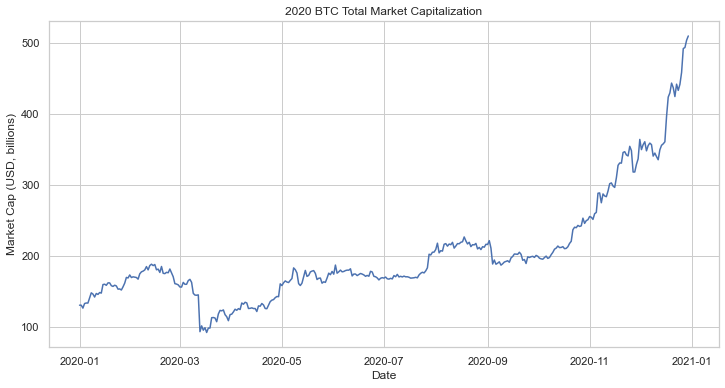

In [16]:
sns.lineplot(data=df_2020, x='Date', y='Market_Cap_Bil')
plt.title(f'2020 BTC Total Market Capitalization')
plt.xlabel('Date')
plt.ylabel('Market Cap (USD, billions)')
plt.show();

Again, the pattern is very similar to the one of 2020 price. It's understandable and makes common sense, since the higher the price - the more the capitalization. We would probably expect the patterns to be similar for all time period too.

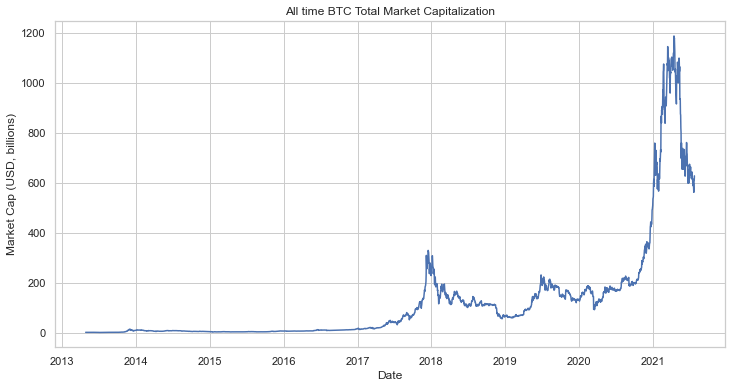

In [17]:
sns.lineplot(data=df, x='Date', y='Market_Cap_Bil')
plt.title(f'All time BTC Total Market Capitalization')
plt.xlabel('Date')
plt.ylabel('Market Cap (USD, billions)')
plt.show();

Indeed, we see the same pattern as for all time price chart.

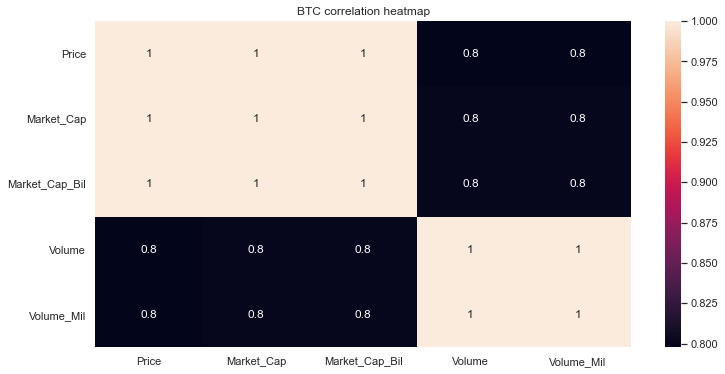

In [18]:
btc_corr = df.corr()
sns.heatmap(btc_corr, annot=True)
plt.title('BTC correlation heatmap')
plt.show();

'Market_Cap' and 'Volume' features have, of course, perfect correlation with 'Market_Cap_Bil' and 'Volume_Mil' respectively.

In [19]:
btc_for_corr = df[['Price', 'Volume_Mil', 'Market_Cap_Bil']]
btc_corr = btc_for_corr.corr()

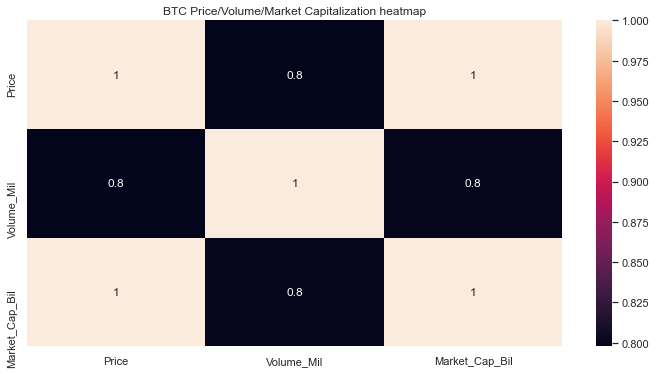

In [20]:
sns.heatmap(btc_corr, annot=True)
plt.title('BTC Price/Volume/Market Capitalization heatmap')
plt.show();

'Price' is strongly correlated with 'Volume_Mil' and perfectly correlated with 'Market_Cap_Bil'. 'Volume_Mil and 'Market_Cap_Bil' are also strongly correlated with each other.

### RANDOM WALK, AUTOCORRELATION AND STATIONARITY

We need to introduce an important term here - random walk - because we want to find out if Bitcoin price is a random walk or not.<br> 
<b>Random Walk</b> - mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers.<br>
In other words, we would like to find out if the price is random or not, because if it is indeed random walk then there is no way we can predict it.<br>
<br>
<b>Autocorrelation</b> is a type of serial dependence when a time series is linearly related to a lagged version of itself.<br>
Why is it important? A lot of time-series forecasting algorithms are based on regression analysis. One of the assumptions we make before peprforming regression analysis is that the data has no autocorrelation. However, if it actually does, then our analysis will be incorrect and misleading.<br>
<br>
<b>Stationarity</b> means that the statistical properties of a process generating a time series do not change over time.<br>
Why is it important? Stationary processes are possible to predict since the way they change is the same over the period of time. The processes themselves might change, but the way they change is constant, making it easier to model.<br>
<br>
We will now use pandas autocorr method to find out Pearson's correlation coefficient - basically, a normalized measurment of covariance, range from -1(perfect negative correlation) to 1(perfect postivie correlation) - and then plot a corellogram (autocorellation function values) of BTC price and see if the process is stationary.

In [21]:
BTC_price = df['Price']

In [22]:
print(BTC_price.autocorr())

0.9986630809622649


In [23]:
BTC_price

0        135.300
1        141.960
2        135.300
3        117.000
4        103.430
          ...   
3002   30928.212
3003   29971.904
3004   32383.781
3005   32409.500
3006   33455.551
Name: Price, Length: 3007, dtype: float64

The coefficient of 0.998 clearly shows that BTC price is strongly autocorrelated. Let's plot the ACF now.

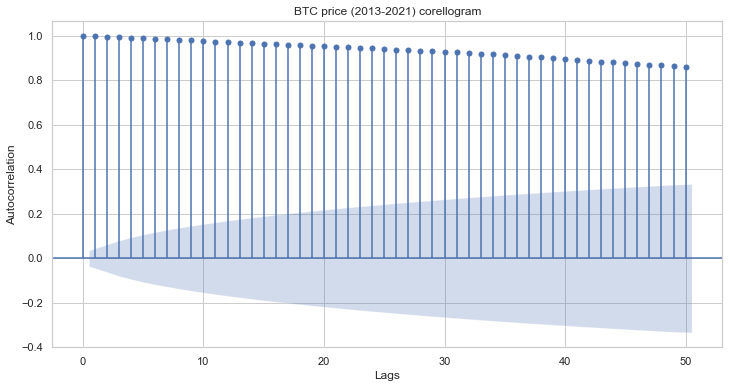

In [24]:
plot_acf(BTC_price, lags=50)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('BTC price (2013-2021) corellogram')
plt.show();

For a stationary process we would expect to see the values of autocorrelation to degrade to zero quickly. However, we don't see it on the plot, and thus we can assume that the process of BTC pricing is not stationary.<br>
Now, let's perform <b>Augmented Dickey-Fuller(ADF)</b> test and make sure that our process is not stationary. The null hypothesis in this test is that a unit root is present in an autoregressive model, and that the process is thus not stationary.<br>
The <b>ADF statistic</b>, used in the test, is a negative number. The <i>more negative</i> it is, the <i>stronger</i> the rejection of the null hypothesis.

In [25]:
result = adfuller(BTC_price)
print('ADF statistic is:', result[0])

ADF statistic is: -0.9014744878526155


We can see that the ADF statistic is -0.9. Let's take a look at the price chart once again.

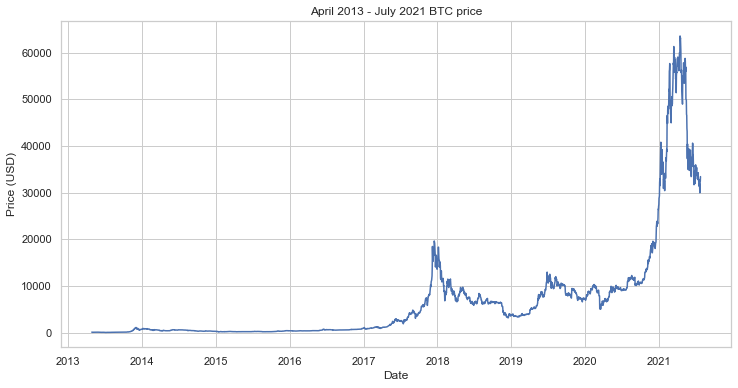

In [26]:
sns.lineplot(data=df, x='Date', y='Price')
plt.title(f'April 2013 - July 2021 BTC price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

Although we don't necessarily see any seasonality, we can clearly see an upward trend.

### HYPOTHESIS TESTING

For those who are familiar with stock market and know what stock price charts look like, those graphs above should seem very close to what you can see in stock market. 
For the random walk, we would expect a strong autocorrelation with the previous observation. We would also expect the values of the time series to be dependent on time. Indeed, from the corellogram we can clearly see that BTC price values depend on time.

We will now formulate hypothesis - null and alternative.<br>
    <b>Null hypothesis</b> - Non Stationarity exists in the series.<br>
    <b>Alternative hypothesis</b> - Stationarity exists in the series<br>
    In order to find out if our Null hypothesis is correct we will perform <b>Augmented Dickey-Fuller Test</b> which is available in statsmodel module for Python. We will not describe the idea of the test here and will just mention that if the p-value will be less than 0.05 then we will be able to reject our Null Hypothesis.

In [27]:
res_norm = adfuller(BTC_price)
print('p-value is:', res_norm[1])

p-value is: 0.7874864598299681


p-value for BTC is 0.78, which is significantly higher than the treshold of 0.05. We <b>fail to reject</b> the null hypothesis. BTC pricing process <b>IS NOT</b> stationary, and we will have to take that into account in our next step - Preprocessing and Training Data Development.

In [28]:
#saving the data
datapath = 'D://Prog/SDST/My Projects/Capstone3/EDA'
if not os.path.exists(datapath):
    os.mkdir(datapath)
datapath_EDA = os.path.join(datapath, 'Data_for_PTDD.csv')
if not os.path.exists(datapath_EDA):
    df.to_csv(datapath_EDA, index=False)
BTC_price.to_pickle('./btc_price.pkl')